# Techincal Setup

## Python

In [1]:
#data processing
import numpy as np
import pandas as pd
import os
import datetime

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots


from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

import warnings
warnings.filterwarnings('ignore')

## R

In [2]:
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.3.1'  

# import rpy2's package module
from rpy2.robjects.packages import importr
from functools import partial
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.ipython import html
html.html_rdataframe=partial(html.html_rdataframe, table_class="docutils")

%load_ext rpy2.ipython

In [3]:
%%R
library(ggplot2)
library(ggstatsplot)
library(tidyverse)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v lubridate 1.9.2     v tibble    3.2.1
v purrr     1.0.1     v tidyr     1.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


You can cite this package as:
     Patil, I. (2021). Visualizations with statistical details: The 'ggstatsplot' approach.
     Journal of Open Source Software, 6(61), 3167, doi:10.21105/joss.03167


# Data Collection

In [8]:
df = pd.read_csv('data\df_clean.csv')

# Derive RFM features
def rfm_segments(df):
    # Champions
    if df['Recency_Score'] >= 4 and df['Frequency_Score'] >= 4 and df['Monetary_Score'] >= 4:
        return 'Champions'
    # New
    elif df['Recency_Score'] >= 4 and df['Frequency_Score'] <= 2:
        return 'New'
    # Promising
    elif df['Recency_Score'] >= 3 and df['Frequency_Score'] <= 2:
        return 'Promising'
    # At Risk
    elif df['Recency_Score'] <= 2 and df['Frequency_Score'] >= 3 and df['Monetary_Score'] >= 3:
        return 'At Risk'
    # Can’t Lose Them
    elif df['Recency_Score'] <= 2 and df['Frequency_Score'] >= 4 and df['Monetary_Score'] >= 4:
        return 'Can’t Lose Them'
    # Lost
    else:
        return 'Lost'

df['RFM_Segment'] = df.apply(rfm_segments, axis=1)

# RFM Analysis

## Correlation

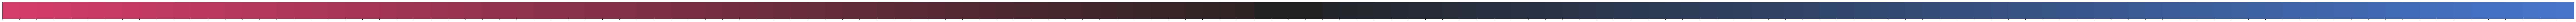

In [4]:
#defining color palette
sns.palplot(sns.diverging_palette(0, 255, sep=8, n=150, center='dark'))

main_facecolor = '#FFFFFF'
main_facecolor2 = '#0D0D0D'
cmap1 = sns.diverging_palette(230, 20, as_cmap=True)
cmap2 = ["#e27c7c", "#a86464", "#6d4b4b", "#503f3f", "#333333", "#3c4e4b", "#466964", "#599e94", "#6cd4c5"]
cmap3 = sns.diverging_palette(0, 255, sep=1, n=50, center='dark')

In [5]:
def is_binary(series, unique_tol=2):
    return series.nunique() <= unique_tol

def mixed_corr(df):
    corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns)
    
    for col1 in df.columns:
        for col2 in df.columns:
            try:
                if is_binary(df[col1]) and is_binary(df[col2]):
                    # Both are binary
                    corr_val = df[col1].corr(df[col2], method='pearson')
                elif is_binary(df[col1]) or is_binary(df[col2]):
                    # One is binary and the other is continuous
                    binary_col = col1 if is_binary(df[col1]) else col2
                    cont_col = col2 if is_binary(df[col1]) else col1
                    corr_val = pointbiserialr(df[cont_col], df[binary_col])[0]
                else:
                    # Both are continuous
                    corr_val = df[col1].corr(df[col2])
                
                corr_matrix.at[col1, col2] = corr_val
            except Exception as e:
                print(f"An error occurred while processing {col1} and {col2}: {e}")
    return corr_matrix

def enforce_symmetry(df):
    return (df + df.T)/2


def plot_heatmap(data, title, figsize=(16, 10)):
    mask = np.triu(np.ones_like(data, dtype=bool))
    fig, ax = plt.subplots(figsize=figsize, facecolor=main_facecolor)
    ax.set_facecolor('#f0f0f0')
    ax.grid(False)
    ax.set_title(title, fontsize=14, fontweight='semibold', fontfamily='sans-serif', color="#413f42",
                 bbox=dict(facecolor='#f0f0f0', edgecolor='#d5d3d6', boxstyle='round,pad=0.6', alpha=0.6))

    _ = sns.heatmap(data, cmap=cmap3, vmax=1, vmin=-1, center=0, square=True, annot=True, linewidths=.5,
                    linecolor='#f0f0f0', cbar_kws={"shrink": .5}, annot_kws={"size": 8}, fmt=".2f")

In [9]:
#creating clustered correlation matrix
df_numeric = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32'])
mixed_corr_matrix = mixed_corr(df_numeric)

dissimilarity = 1 - abs(mixed_corr_matrix)

# Enforce symmetry
symmetric_dissimilarity = enforce_symmetry(dissimilarity)

# Set diagonal to zero
np.fill_diagonal(symmetric_dissimilarity.values, 0)

# Check for symmetry
print((symmetric_dissimilarity.T == symmetric_dissimilarity).all().all())

# Proceed with clustering
Z = linkage(squareform(symmetric_dissimilarity), 'ward')

#Clusterize the data
threshold = 0.8
labels = fcluster(Z, threshold, criterion='distance')

# Keep the indices to sort labels
labels_order = np.argsort(labels)

# Build a new dataframe with the sorted columns
for idx, i in enumerate(df_numeric.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(df_numeric[i])
    else:
        df_to_append = pd.DataFrame(df_numeric[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

clustered_corr = clustered.corr()

True


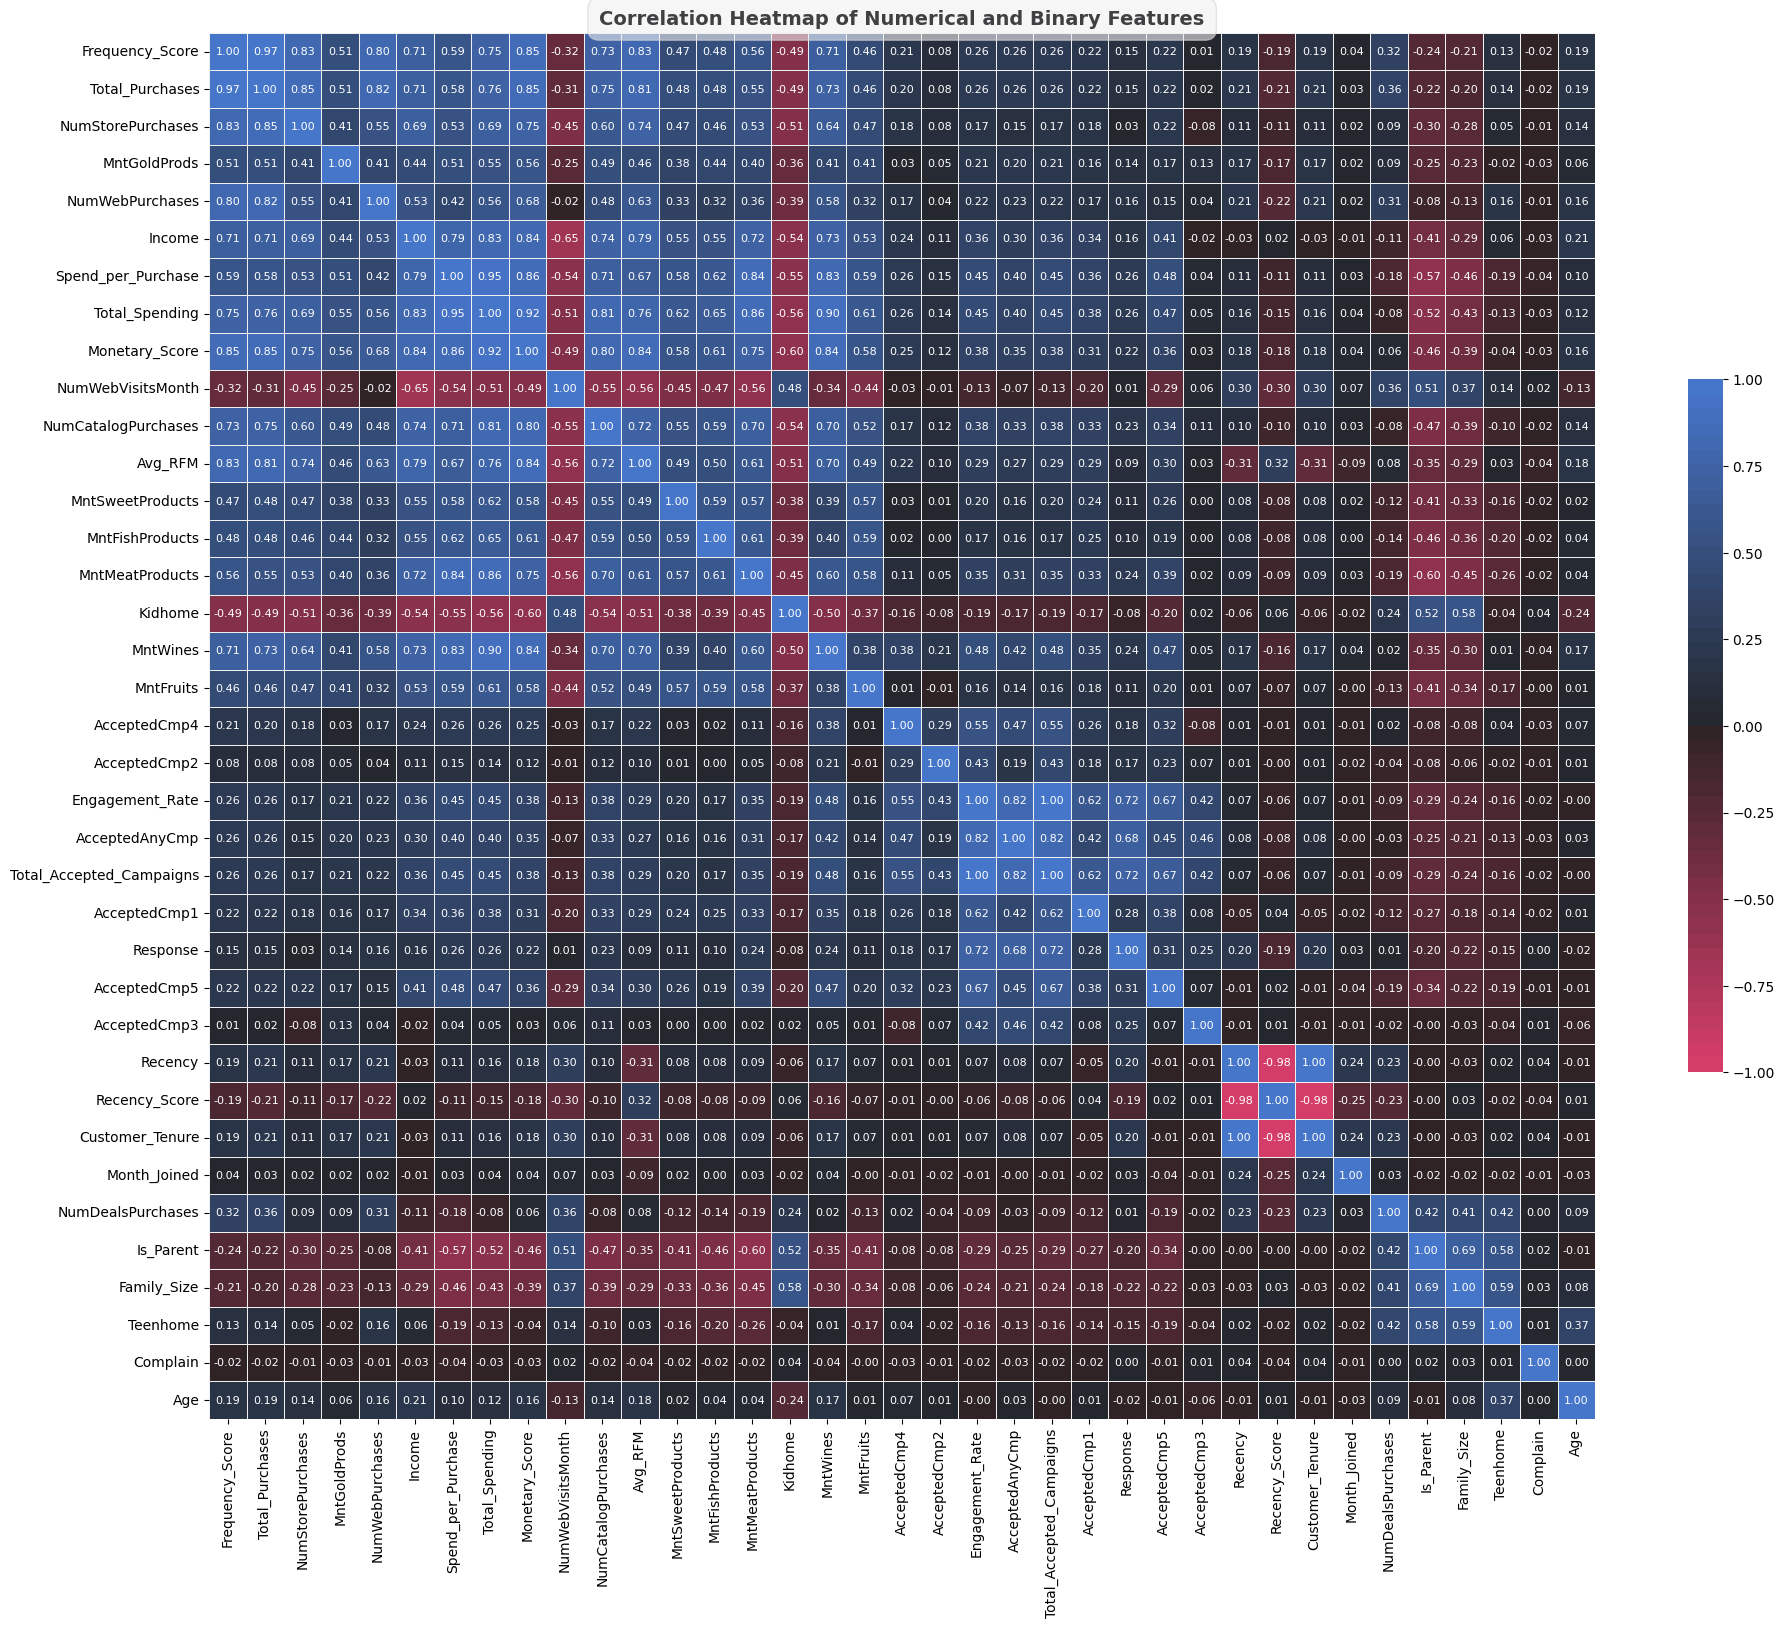

In [11]:
# Plot heatmap for categorical and binary variables
plot_heatmap(clustered_corr.astype(float), title='Correlation Heatmap of Numerical and Binary Features', figsize=(24, 18))

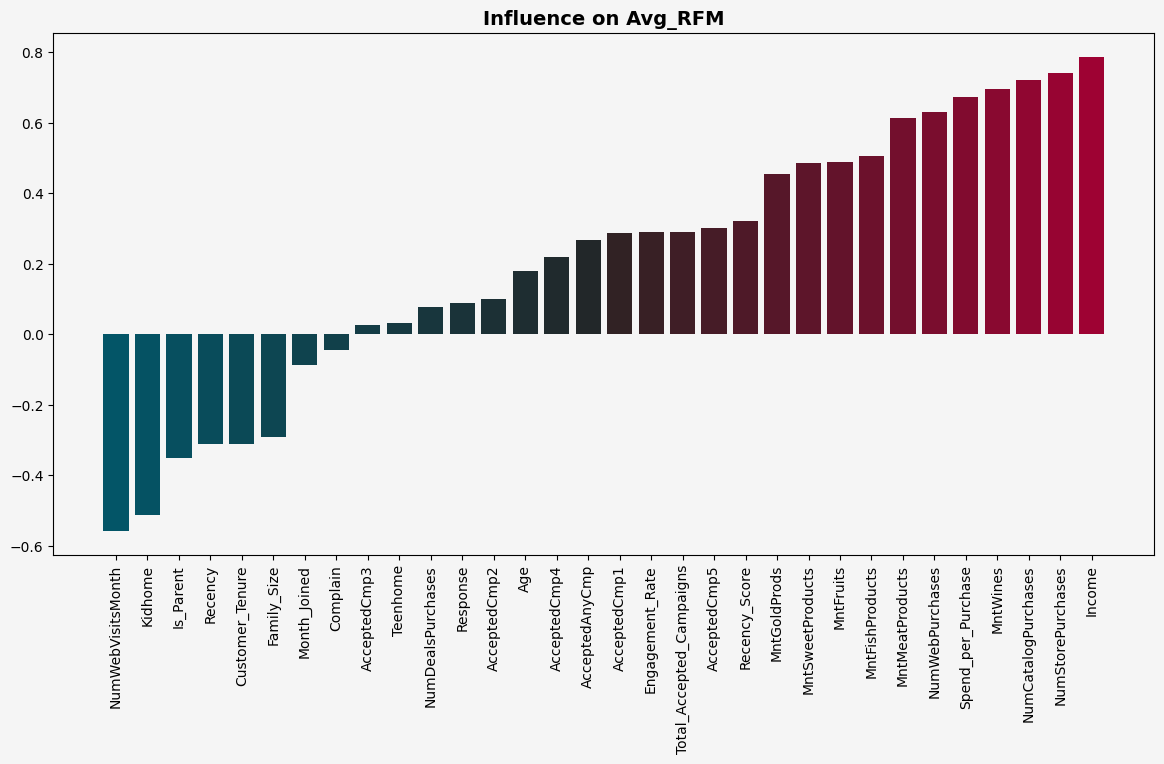

In [12]:
#function to plot the bar
def plot_df_bar2(df, title, settings, horizontal=False):
    fig, ax = plt.subplots(figsize=settings['figsize'])
    cmap = sns.diverging_palette(h_neg=220, h_pos=5, s=99, l=33, sep=5, n=32, center='dark')

    ax.set_facecolor('whitesmoke')
    fig.set_facecolor('whitesmoke')
    
    if not horizontal:
        ax.bar(df.index, df.values, color=cmap, width=settings['width'])
        ax.set_xlabel(settings['x_label'], fontsize=settings['fontsize_axes_label'])
        ax.set_ylabel(settings['y_label'], fontsize=settings['fontsize_axes_label'])
    else:
        ax.barh(df.index, df.values, color=cmap, height=settings['width'])  # Use ax.barh for horizontal bars
        ax.set_ylabel(settings['x_label'], fontsize=settings['fontsize_axes_label'])  # Swap x and y labels
        ax.set_xlabel(settings['y_label'], fontsize=settings['fontsize_axes_label'])  # Swap x and y labels

    ax.set_title(title, fontsize=settings['fontsize_title'], fontweight='bold')
    ax.grid(False)

    if horizontal:
        plt.yticks(rotation=settings['x_label_rotation'])  # Rotate y-ticks if horizontal
    else:
        plt.xticks(rotation=settings['x_label_rotation'])

    plt.tight_layout(pad=2)
    plt.show()

def plot_bar(df, title, horizontal=False, **kwargs):
    bar_setting_dict={
                    'x_label' : '',
                    'y_label' : '',
                    'figsize' :(6,4),
                    'layout' : (1, 1),
                    'width' : 0.3,
                    'align' : 'center',
                    'fontsize_legend': 14,
                    'x_label_rotation': 0,
                    'subplots' : False,
                    'fontsize_title' : 14,
                    'fontsize_axes_values' : 14,
                    'fontsize_axes_label' : 14,
                    'fontsize_text' : 14,
                    'fontsize_legend' : 14,
                    'set_yticks_range' : False,
                    'yticks_start' : None,
                    'yticks_end' : None,
                    'yticks_step' : None,
                    'legend_state' : False,
                    'legend_list_to_plot' : '',
                    'legend_move' : False,
                    'legend_x' : None,
                    'legend_y' : None}
                    
    for key, value in kwargs.items():
        bar_setting_dict[key] = value

    plot_df_bar2(df, title, bar_setting_dict, horizontal=horizontal)

corr_pairs = clustered_corr.unstack().sort_values()
rfm_features = ['Avg_RFM', 'Frequency_Score', 'Monetary_Score', 'Total_Spending', 'Total_Purchases']
corr_rfm = corr_pairs['Avg_RFM'].drop(rfm_features, axis=0)
plot_bar(corr_rfm, title='Influence on Avg_RFM', width=0.8, figsize=(12, 8), x_label_rotation=90, horizontal=False)


In [ ]:
df.reset_index

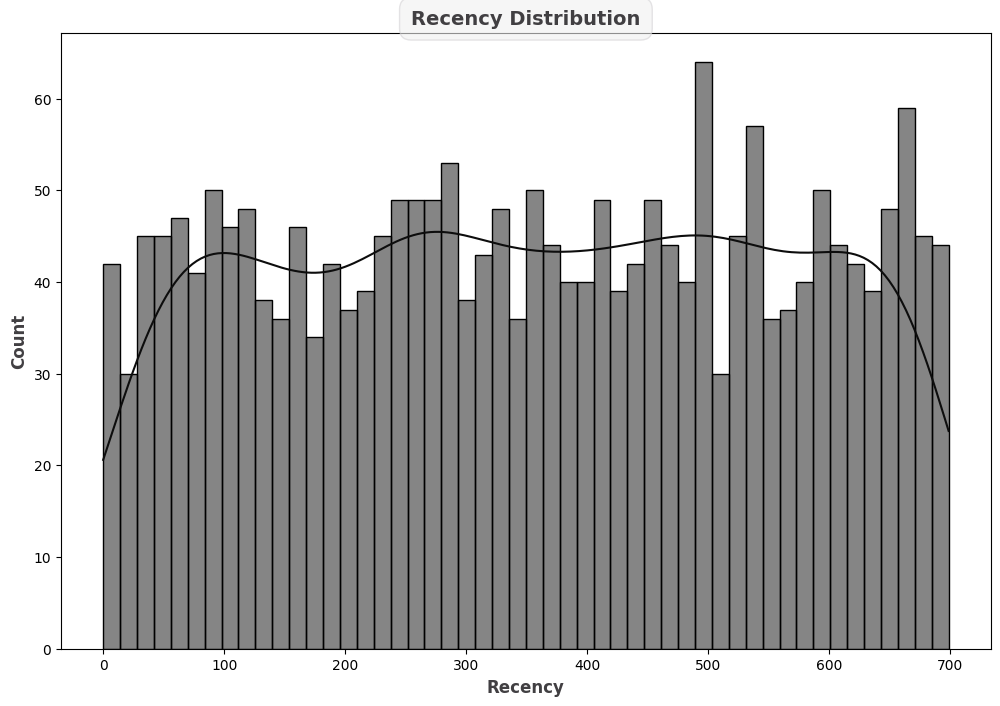

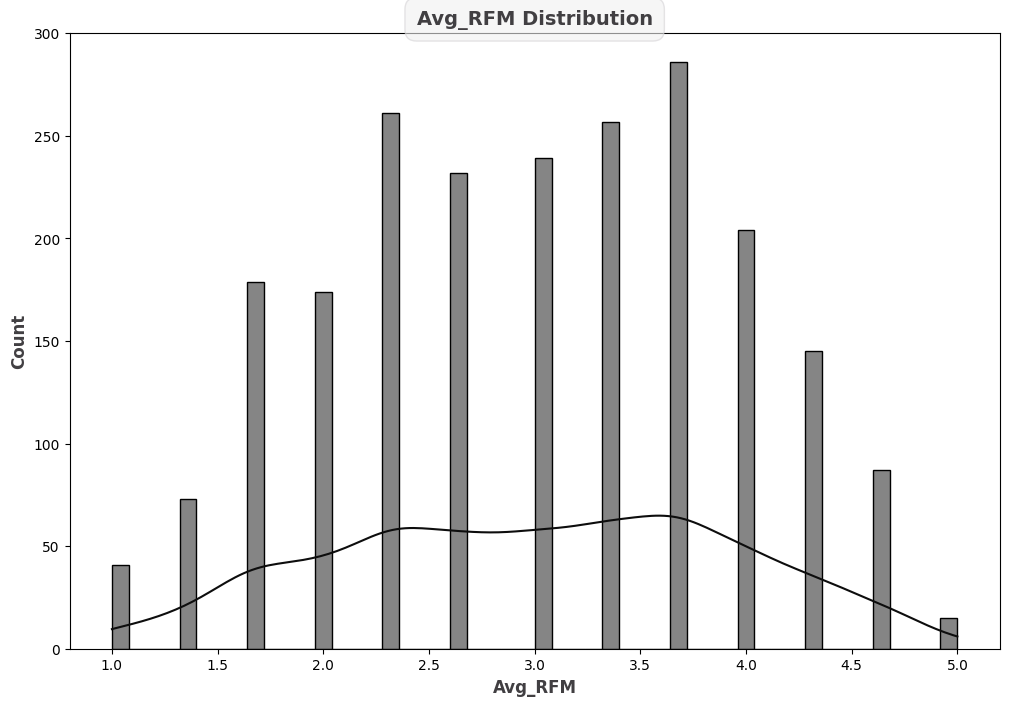

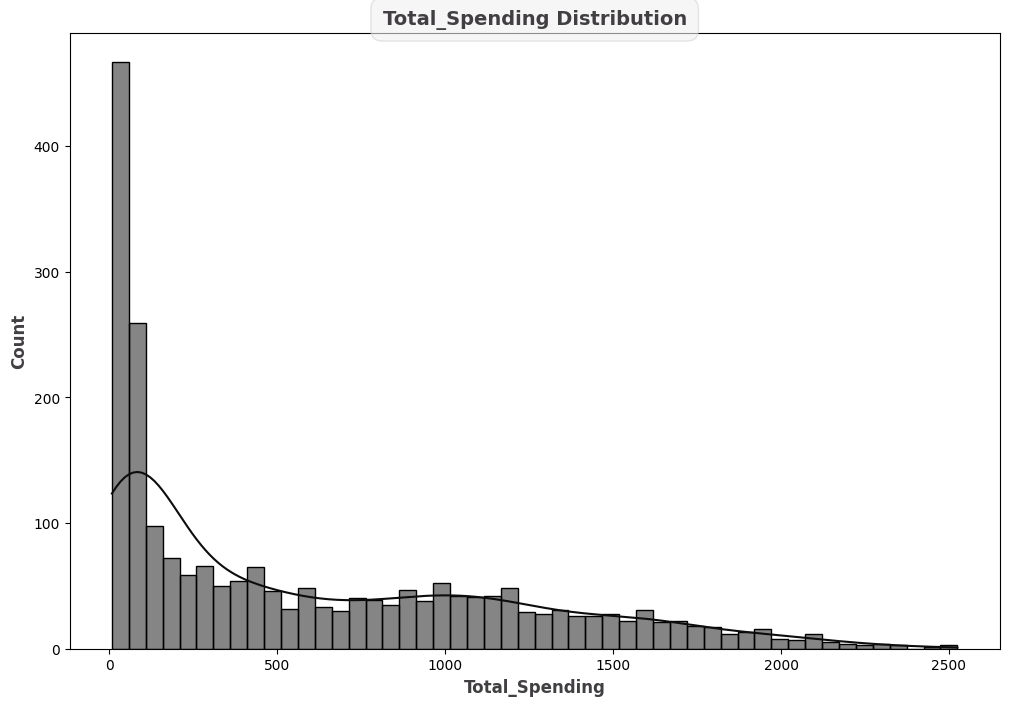

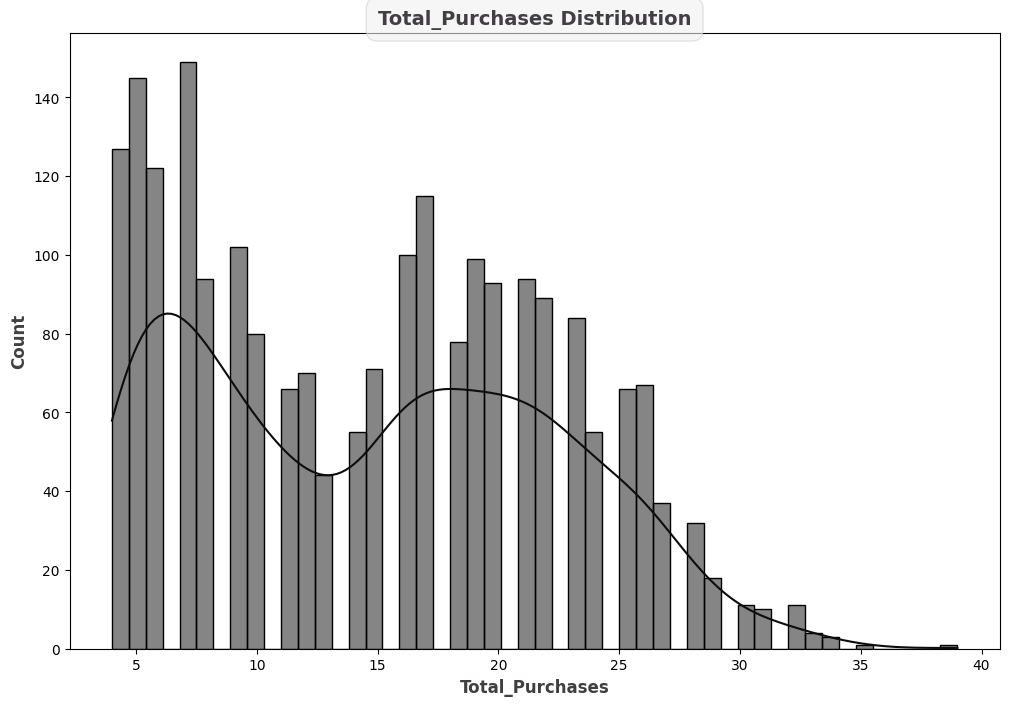

In [33]:
#create function from the above code
def plot_hist(df, column, title, bins=50, kde=True, color='#0D0D0D', figsize=(12, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.histplot(df[column], bins=bins, kde=kde, color=color, ax=ax)
    ax.set_title(title, fontsize=14, fontweight='semibold', fontfamily='sans-serif', color="#413f42",
                bbox=dict(facecolor='#f0f0f0', edgecolor='#d5d3d6', boxstyle='round,pad=0.6', alpha=0.6))
    ax.set_xlabel(column, fontsize=12, fontweight='semibold', fontfamily='sans-serif', color="#413f42")
    ax.set_ylabel('Count', fontsize=12, fontweight='semibold', fontfamily='sans-serif', color="#413f42")
    ax.grid(False)
    plt.show()

plot_hist(df, 'Recency', 'Recency Distribution', bins=50, kde=True, color='#0D0D0D', figsize=(12, 8))

plot_hist(df, 'Avg_RFM', 'Avg_RFM Distribution', bins=50, kde=True, color='#0D0D0D', figsize=(12, 8))

plot_hist(df, 'Total_Spending', 'Total_Spending Distribution', bins=50, kde=True, color='#0D0D0D', figsize=(12, 8))

plot_hist(df, 'Total_Purchases', 'Total_Purchases Distribution', bins=50, kde=True, color='#0D0D0D', figsize=(12, 8))


In [28]:
#perform comparisons on various metrics by RFM_Segment
df_rfm = df.groupby(['RFM_Segment']).agg({'Age': 'mean', 'Recency': 'mean', 'Total_Purchases': 'mean', 'Total_Spending': 'mean', 'Engagement_Rate':'mean'}).reset_index()
df_rfm.columns = ['RFM_Segment', 'Age_Median', 'Recency_Mean', 'Frequency_Mean', 'Monetary_Mean', 'Engagement_Rate_Median']

#create customer count using index as id
df_rfm['Customer_Count'] = df.groupby(['RFM_Segment']).size().reset_index(drop=True)
df_rfm['Customer_Percent'] = df_rfm['Customer_Count'] / df_rfm['Customer_Count'].sum() * 100



In [24]:
df_rfm

,RFM_Segment,Customer_Count,Recency_Mean,Frequency_Mean,Monetary_Mean
0,At Risk,55.0,567.77,21.28,1018.82
1,Champions,54.0,153.57,22.34,1240.36
2,Lost,53.0,373.77,13.79,504.89
3,New,51.0,133.14,7.04,72.09
4,Promising,51.0,350.26,6.68,67.75


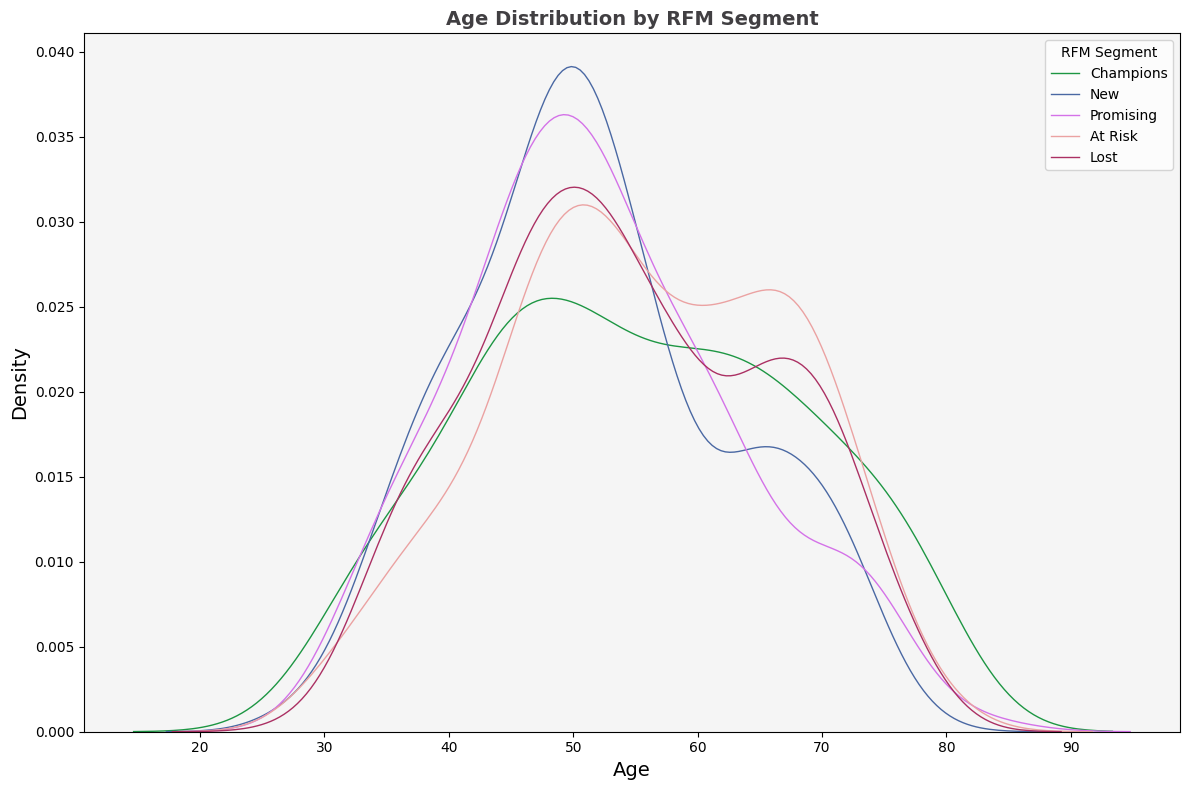

In [12]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Age Distribution by RFM Segment', fontsize=14, fontweight='semibold', color="#413f42")
ax.set_facecolor('#f5f5f5')
rfm_segments = ['Champions', 'New', 'Promising', 'At Risk', 'Lost']
colors = ['#1d9643', '#4a68a3', '#d472e8', '#eba2a2', '#ab3063']

for segment, color in zip(rfm_segments, colors):
    sns.kdeplot(data=df[df['RFM_Segment'] == segment]['Age'], color=color, ax=ax, label=segment, linewidth=1)

ax.set_xlabel('Age', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.legend(loc='upper right', title='RFM Segment')
plt.tight_layout()
plt.show()
                

In [13]:
#create crosstab Education and Marital_Status
pd.crosstab(df['Education'], df['Marital_Status'], margins=True)


Marital_Status,Divorced,Married,Single,Together,Widow,All
Education,,,,,,
2n Cycle,22,81,36,56,5,200
Basic,1,20,18,14,1,54
Graduation,116,427,245,281,33,1102
Master,36,136,75,105,12,364
PhD,52,186,99,112,24,473
All,227,850,473,568,75,2193


Trimmed mean of engagement rate: 5.13%


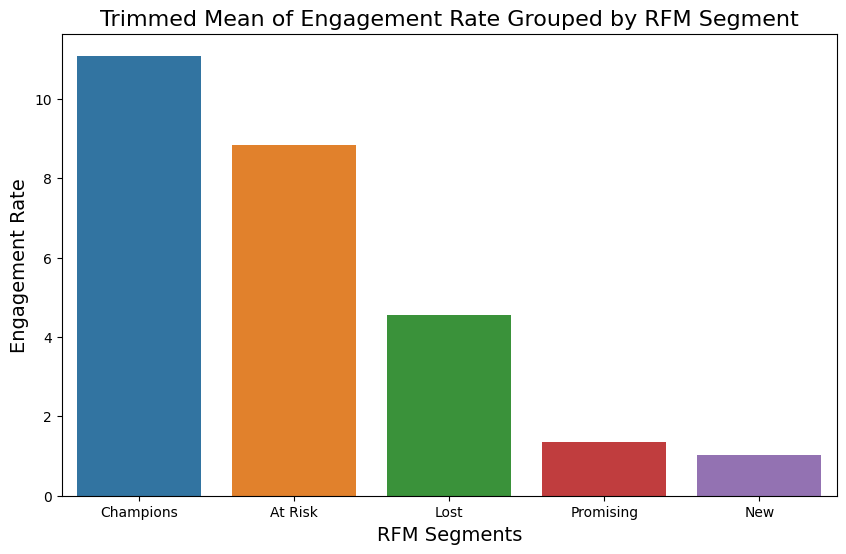

In [14]:
#create a function to calculate trimmed mean
def trimmed_mean(data, trim=0.05):
    n = len(data)
    k = int(round(n*trim))
    data = np.sort(data)
    return np.mean(data[k:-k])

#calculate trimmed mean of engagement rate
print('Trimmed mean of engagement rate: {:.2f}%'.format(trimmed_mean(df['Engagement_Rate'])))

#calculate trimmed mean of engagement rate grouped by month joined
df_trimmed_mean = df.groupby('RFM_Segment')['Engagement_Rate'].apply(trimmed_mean).reset_index()
df_trimmed_mean['Engagement_Rate'] = df_trimmed_mean['Engagement_Rate']
df_trimmed_mean = df_trimmed_mean.sort_values(by='Engagement_Rate', ascending=False)

#plot trimmed mean of engagement rate grouped by month joined
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=df_trimmed_mean, x='RFM_Segment', y='Engagement_Rate', ax=ax)
ax.set_title('Trimmed Mean of Engagement Rate Grouped by RFM Segment', fontsize=16)
ax.set_xlabel('RFM Segments', fontsize=14)
ax.set_ylabel('Engagement Rate', fontsize=14)
plt.show()

In [18]:
df_trimmed_mean

,RFM_Segment,Engagement_Rate
1,Champions,11.084142
0,At Risk,8.825397
2,Lost,4.562648
4,Promising,1.345756
3,New,1.014109


In [8]:
print('Trimmed mean of Engagement Rate: {:.2f}'.format(trimmed_mean(df['Engagement_Rate'])))
print('Trimmed mean of Customer Tenure: {:.2f}'.format(trimmed_mean(df['Customer_Tenure'])))
print('Trimmed mean of Average RFM: {:.2f}'.format(trimmed_mean(df['Avg_RFM'])))


Trimmed mean of Engagement Rate: 0.71
Trimmed mean of Customer Tenure: 356.09
Trimmed mean of Average RFM: 3.01


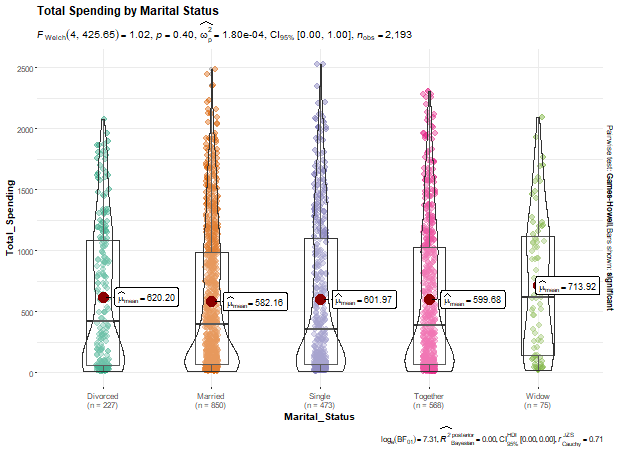

In [9]:
%%R -i df -w 22 -h 16 -u cm

ggbetweenstats(
  data  = df,
  x     = Marital_Status,
  y     = Total_Spending,
  title = "Total Spending by Marital Status"
)

- The t-bootstrapped value of -106.13 is very significant, with a p-value of 0.00. This means that we can reject the null hypothesis that the mean engagement rate is equal to 7.51, with 95% confidence.

- The 95% confidence interval for the mean engagement rate is [5.05, 9.97]. This means that we can be 95% confident that the true mean engagement rate is within this range.

- The mean trimmed value of 7.51 is the mean of the data after removing the top and bottom 25% of the values. This is a more robust measure of the mean than the regular mean, as it is less affected by outliers.